In [55]:
import pandas as pd

In [223]:
def load_spc_csv():
    # https://docs.google.com/spreadsheets/d/1_CJynawjob9yqRSbEM1Mmtn7ZigWAKby_W9iKmi3wlM/edit?gid=1251724745#gid=1251724745
    supercon_csv = "./supercon.csv"
    spc_df = pd.read_csv(supercon_csv)

    # 'Magnetic property',
    # 'Material',
    # 'Mechanical property',
    # 'Normal state property',
    # 'Preparation',
    # 'Structure',
    # 'Superconductivity',
    # 'Thermal property'
    readable_category_names = {
        'Material': "Material",
        'Magnetic property': "Magnetic",
        'Mechanical property': "Mechanical",
        'Normal state property': "Normal State",
        'Thermal property': "Thermal",
        'Preparation': "Preparation",
        'Structure': 'Structural',
        'Superconductivity': 'Superconductivity',
    }
    spc_df["category"] = spc_df["category"].map(readable_category_names)
    return spc_df

def load_cdw_csv():
    # https://docs.google.com/spreadsheets/d/1HN_bpip2LBtyWwcPlYQpy_iWZ_8_PcAX3dLE1z1MLa8/edit?gid=1271233163#gid=1271233163
    cdw_csv = "./cdw.csv"

    cdw_df = pd.read_csv(cdw_csv)
    cdw_df = cdw_df[cdw_df["is_condition"] == False]
    return cdw_df.copy()

def load_bsf_csv():
    # https://docs.google.com/spreadsheets/d/1IbiFwHcjTNi2tGCkQO_eOD_pTkL1Qetk_6r3xIq4B6c/edit?gid=2126313334#gid=2126313334
    biosurfactants_csv = "./biosurfactants.csv"
    # https://docs.google.com/spreadsheets/d/1IbiFwHcjTNi2tGCkQO_eOD_pTkL1Qetk_6r3xIq4B6c/edit?gid=1966299312#gid=1966299312
    biosurfactants_frequency_csv = "./biosurfactant_frequency.csv"
    
    bsf_df_cat = pd.read_csv(biosurfactants_csv)
    bsf_tmp_a = bsf_df_cat[~bsf_df_cat["category"].isna()].copy()
    bsf_tmp_a.loc[:,"property_name_cleaned"] = bsf_tmp_a["property_name"].str.split("(", n=1).str[0].str.strip()
    
    bsf_freq_df = pd.read_csv(biosurfactants_frequency_csv)
    bsf_tmp_b = bsf_freq_df[bsf_freq_df.columns[:2]].copy()
    
    # there are some property names that are further categorized but in the original
    # sheet those distinctions do not exist, hence we aggregate them to their parent
    # category. For example the counts of:
    # - Particulate Dispersion (Cross-sectional Size)
    # - Particulate Dispersion (Natural Settling)
    # will both be summed and considered of category "Particulate Dispersion"
    bsf_tmp_b.loc[:,"property_name_cleaned"] = bsf_tmp_b["property_name"].str.split("(", n=1).str[0].str.strip()
    bsf_tmp_b["count"] = bsf_tmp_b["count"].astype(float)
    bsf_tmp_b = bsf_tmp_b[["property_name_cleaned", "count"]].groupby(["property_name_cleaned"]).sum()

    bsf_df = bsf_tmp_a.merge(bsf_tmp_b, on=['property_name_cleaned'], how='outer')
    bsf_df = bsf_df[~bsf_df["count"].isna()]
    del bsf_df["property_name_cleaned"]
    
    readable_category_names = {
        'biological_and_kinetic_properties': "Biological, Kinetic",
        'interfacial_and_surface_properties': "Interfacial, Surface",
        'physicochemical_and_phase_properties': "Physiochemical, Phase",
        'rheological_and_physical_properties': "Rheological, Physical",
        'soil_handling_and_electrostatic_properties': "Soil Handling, Electrostatic",
    }

    bsf_df["category"] = bsf_df["category"].map(readable_category_names)
    return bsf_df.copy()

In [224]:
def get_all_agg_dataset():
    spc_df = load_spc_csv()[["property_name", "count", "category"]]
    spc_df["dataset"] = "SuperCon"

    cdw_df = load_cdw_csv()[["property_name", "count", "category"]]
    cdw_df["dataset"] = "CDW"

    bsf_df = load_bsf_csv()[["property_name", "count", "category"]]
    bsf_df["dataset"] = "Biosurfactants"

    all_data = pd.concat([spc_df, cdw_df, bsf_df])
    return all_data.copy()

In [225]:
get_all_agg_dataset().to_csv("./all_data_categories.csv", index=False)

### Sunburst Plot

All levels.

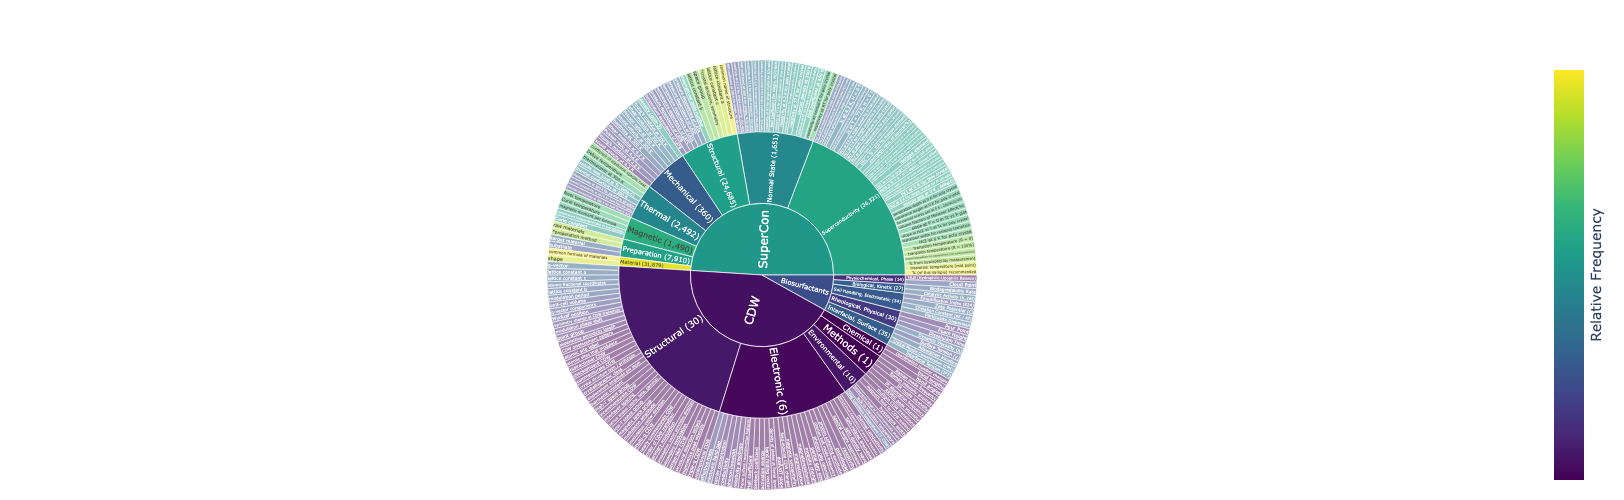

In [266]:
import math
import pandas as pd
import plotly.graph_objects as go
from plotly.colors import sequential

CSV_PATH = "./all_data_categories.csv"
df = pd.read_csv(CSV_PATH)

# -----------------------------
# Validate / clean
# -----------------------------
required = {"dataset", "category", "property_name", "count"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing required columns: {sorted(missing)}")

df = df.copy()
df["dataset"] = df["dataset"].astype(str).str.strip()
df["category"] = df["category"].astype(str).str.strip()
df["property_name"] = df["property_name"].astype(str).str.strip()

df["count"] = pd.to_numeric(df["count"], errors="coerce").fillna(0)

# Stable ordering: categories alpha; properties by count desc then name
df = df.sort_values(
    ["dataset", "category", "count", "property_name"],
    ascending=[True, True, False, True],
    kind="mergesort",
)

def log10_clip(x: float) -> float:
    # Log scale for color; treat nonpositive as 1 for log
    return math.log10(x if x > 0 else 1.0)

df["count_log10"] = [log10_clip(x) for x in df["count"].tolist()]

# -----------------------------
# Build hierarchical node lists for go.Sunburst
# - Area encodes diversity: each property leaf has value=1
# - Color encodes prevalence: log10(count) on leaves; internal nodes get mean of descendants
# -----------------------------
nodes = {}  # id -> dict(label, parent, value, color, hover_count)

def ensure_node(node_id: str, label: str, parent: str | None):
    if node_id not in nodes:
        nodes[node_id] = {
            "id": node_id,
            "label": label,
            "parent": parent if parent is not None else "",
            "value": 0,
            "color": None,
            "hover_count": None,
            "leaf_colors": [],   # collect leaf colors for internal aggregation
            "leaf_counts": [],   # collect raw counts for internal hover (optional)
        }

# Add all nodes
for r in df.itertuples(index=False):
    ds = r.dataset
    cat = r.category
    prop = r.property_name
    cnt = float(r.count)
    c = float(r.count_log10)

    ds_id = f"ds::{ds}"
    cat_id = f"cat::{ds}::{cat}"
    prop_id = f"prop::{ds}::{cat}::{prop}"

    ensure_node(ds_id, ds, None)
    ensure_node(
        cat_id, 
        #cat, 
        cat + f" ({int(r.count):,})",
        ds_id
    )
    ensure_node(prop_id, prop, cat_id)

    # Leaf: equal weight for diversity
    nodes[prop_id]["value"] = 1
    nodes[prop_id]["color"] = c
    nodes[prop_id]["hover_count"] = cnt

    # Accumulate to parents
    nodes[cat_id]["value"] += 1
    nodes[ds_id]["value"] += 1

    nodes[cat_id]["leaf_colors"].append(c)
    nodes[ds_id]["leaf_colors"].append(c)

    nodes[cat_id]["leaf_counts"].append(cnt)
    nodes[ds_id]["leaf_counts"].append(cnt)

# Aggregate internal node colors (mean of descendant leaves)
for nid, nd in nodes.items():
    if nd["color"] is None:
        if nd["leaf_colors"]:
            nd["color"] = sum(nd["leaf_colors"]) / len(nd["leaf_colors"])
        else:
            nd["color"] = 0.0  # fallback

# Build arrays for Plotly
ids = []
labels = []
parents = []
values = []
colors = []
customdata = []  # [count, log10(count)] for leaves; for internal, summarize

for nid, nd in nodes.items():
    ids.append(nd["id"])
    labels.append(nd["label"])
    parents.append(nd["parent"])
    values.append(nd["value"])
    colors.append(nd["color"])

    if nd["hover_count"] is not None:
        customdata.append([nd["hover_count"], nd["color"]])
    else:
        # Provide internal summaries instead of raw count
        # (Count is not meaningful on internal nodes; we show number of properties and mean log10(count))
        customdata.append([None, nd["color"]])

# Sunburst figure
fig = go.Figure(
    go.Sunburst(
        ids=ids,
        labels=labels,
        parents=parents,
        values=values,
        branchvalues="total",
        marker=dict(
            colors=colors,
            colorscale=sequential.Viridis,
            line=dict(width=0.7),
            showscale=True,
            colorbar=dict(
                showticklabels=False,
                title=dict(
                    text="Relative Frequency",
                    side="right",     # place title on the right
                    #textangle=90,     # rotate vertically
                ),
                outlinewidth=0,
                ticks="",
                #shadow=True,
            ),
        ),
        customdata=customdata,
        insidetextorientation="radial",
        leaf=dict(opacity=0.5)
    )
)

fig.update_layout(
    #title="Dataset → Category → Property taxonomy (area = diversity; color = prevalence)",
    margin=dict(t=60, l=10, r=10, b=10),
    width=500,
    height=500,
)
fig.update_traces(
    insidetextorientation="radial",
    outsidetextfont=dict(size=18),
)

fig.show()

#fig.write_image("taxonomy_sunburst.svg", width=1400, height=1100)
#fig.write_image("taxonomy_sunburst.pdf", width=1400, height=1100)
# fig_hm.write_image("category_dataset_heatmap.svg", width=1000, height=700)

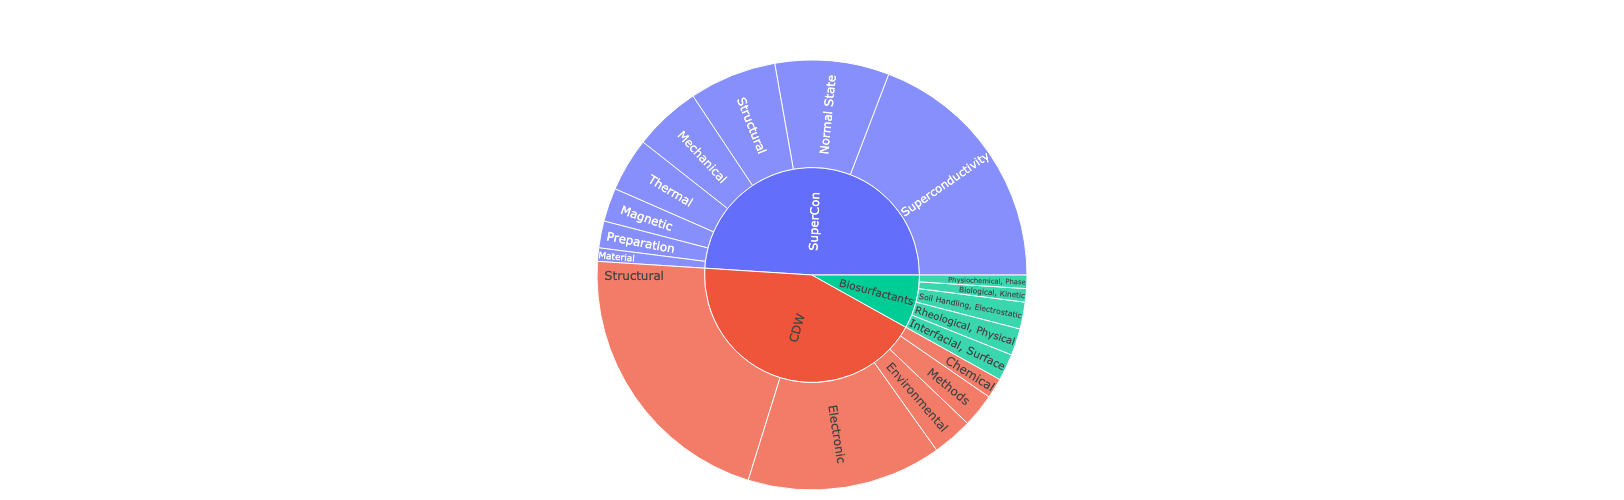

In [358]:
import math
import pandas as pd
import plotly.graph_objects as go
from plotly.colors import sequential

CSV_PATH = "./all_data_categories.csv"
df = pd.read_csv(CSV_PATH)

# -----------------------------
# Validate / clean
# -----------------------------
required = {"dataset", "category", "property_name", "count"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing required columns: {sorted(missing)}")

df = df.copy()
df["dataset"] = df["dataset"].astype(str).str.strip()
df["category"] = df["category"].astype(str).str.strip()
df["property_name"] = df["property_name"].astype(str).str.strip()
df["count"] = pd.to_numeric(df["count"], errors="coerce").fillna(0)

def log10_clip(x: float) -> float:
    return math.log10(x if x > 0 else 1.0)

df["count_log10"] = df["count"].map(log10_clip)

# -----------------------------
# Collapse to Dataset -> Category (NO property nodes)
# -----------------------------
# n_properties drives area; mean log10(count) drives color
g = (
    df.groupby(["dataset", "category"], as_index=False)
      .agg(
          n_properties=("property_name", "nunique"),
          mean_log10=("count_log10", "mean"),
          sum_count=("count", "sum"),
      )
)

# Dataset-level aggregates for hover + color
ds = (
    g.groupby("dataset", as_index=False)
     .agg(
         n_categories=("category", "nunique"),
         n_properties=("n_properties", "sum"),
         sum_count=("sum_count", "sum"),
     )
)

# Weighted mean log10 for dataset color (weights = n_properties)
ds_color = (
    g.assign(w=g["n_properties"])
     .groupby("dataset", as_index=False)
     .apply(lambda x: (x["mean_log10"] * x["w"]).sum() / max(x["w"].sum(), 1))
     .rename(columns={None: "mean_log10"})
)
ds = ds.merge(ds_color, on="dataset", how="left")

# -----------------------------
# Build node arrays for Plotly Sunburst
# -----------------------------
ids, labels, parents, values, colors, customdata = [], [], [], [], [], []

# Dataset nodes
for r in ds.sort_values(["dataset"], kind="mergesort").itertuples(index=False):
    ds_id = f"ds::{r.dataset}"
    ids.append(ds_id)
    labels.append(r.dataset)
    parents.append("")
    values.append(int(r.n_properties))                 # total properties under dataset (area)
    #values.append(int(33))
    colors.append(float(r.mean_log10))                 # weighted mean log10(count)
    customdata.append([int(r.n_categories), int(r.n_properties), float(r.sum_count), float(r.mean_log10)])

# Category nodes
g_sorted = g.sort_values(["dataset", "category"], kind="mergesort")
for r in g_sorted.itertuples(index=False):
    ds_id = f"ds::{r.dataset}"
    cat_id = f"cat::{r.dataset}::{r.category}"
    ids.append(cat_id)
    # TODO: fix, this is wrong, need num of categories not freq in dataset
    #labels.append(r.category + f" ({int(r.sum_count):,})")
    labels.append(r.category)
    parents.append(ds_id)
    values.append(int(r.n_properties))                 # number of properties in this category (area)
    colors.append(float(r.mean_log10))                 # mean log10(count) within category
    customdata.append([None, int(r.n_properties), float(r.sum_count), float(r.mean_log10)])

# -----------------------------
# Sunburst figure
# -----------------------------
fig = go.Figure(
    go.Sunburst(
        ids=ids,
        labels=labels,
        parents=parents,
        values=values,
        branchvalues="total",
        customdata=customdata,
        insidetextorientation="radial",
        leaf=dict(opacity=0.77),
    )
)

fig.update_layout(
    margin=dict(t=60, l=10, r=10, b=10),
    width=500,
    height=500,
)

fig.update_traces(
    outsidetextfont=dict(size=18),
)
fig.show()

In [357]:
#!pip install kaleido==0.2.1

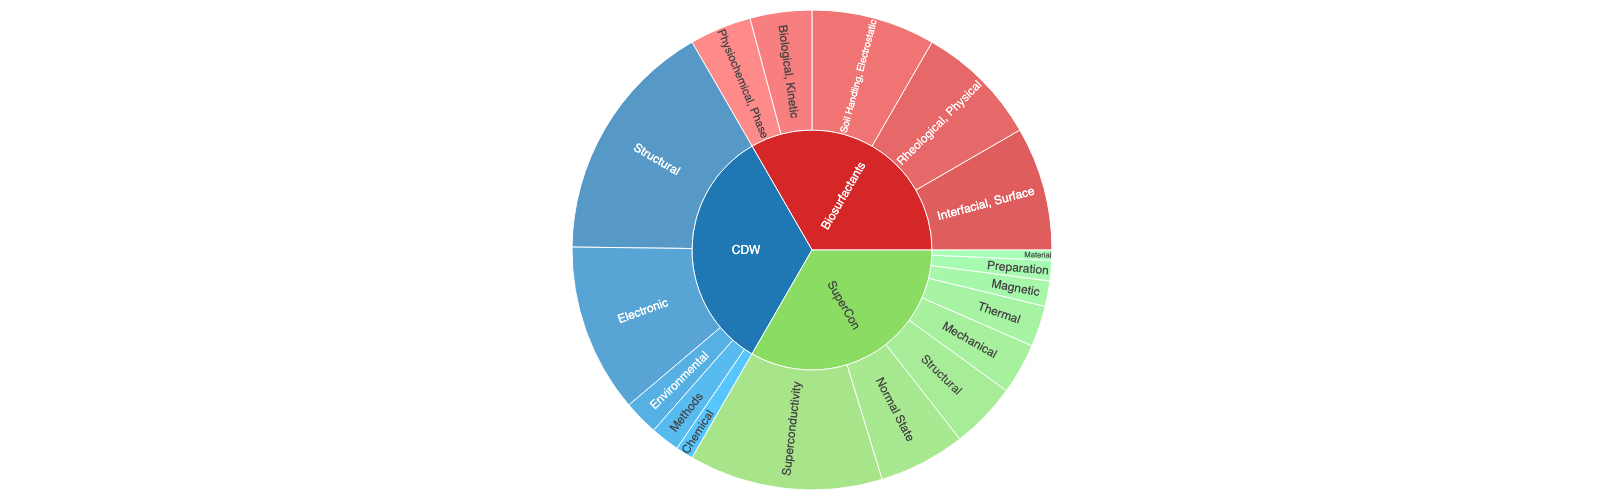

In [359]:
import math
import pandas as pd
import plotly.graph_objects as go
from plotly.colors import sequential

CSV_PATH = "./all_data_categories.csv"
df = pd.read_csv(CSV_PATH)

# -----------------------------
# Validate / clean
# -----------------------------
required = {"dataset", "category", "property_name", "count"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing required columns: {sorted(missing)}")

df = df.copy()
df["dataset"] = df["dataset"].astype(str).str.strip()
df["category"] = df["category"].astype(str).str.strip()
df["property_name"] = df["property_name"].astype(str).str.strip()
df["count"] = pd.to_numeric(df["count"], errors="coerce").fillna(0)

def log10_clip(x: float) -> float:
    return math.log10(x if x > 0 else 1.0)

df["count_log10"] = df["count"].map(log10_clip)

# -----------------------------
# Collapse to Dataset -> Category (NO property nodes)
# -----------------------------
# n_properties drives area; mean log10(count) drives color
g = (
    df.groupby(["dataset", "category"], as_index=False)
      .agg(
          n_properties=("property_name", "nunique"),
          mean_log10=("count_log10", "mean"),
          sum_count=("count", "sum"),
      )
)

# Dataset-level aggregates for hover + color
ds = (
    g.groupby("dataset", as_index=False)
     .agg(
         n_categories=("category", "nunique"),
         n_properties=("n_properties", "sum"),
         sum_count=("sum_count", "sum"),
     )
)

# Weighted mean log10 for dataset color (weights = n_properties)
ds_color = (
    g.assign(w=g["n_properties"])
     .groupby("dataset", as_index=False)
     .apply(lambda x: (x["mean_log10"] * x["w"]).sum() / max(x["w"].sum(), 1))
     .rename(columns={None: "mean_log10"})
)
ds = ds.merge(ds_color, on="dataset", how="left")

ids, labels, parents, values, customdata = [], [], [], [], []

ds_sorted = ds.sort_values(["dataset"], kind="mergesort").reset_index(drop=True)



RED_BASE = "rgb(214,39,40)"
BLUE_BASE = "rgb(31,119,180)"
GREEN_BASE = "rgb(138,220,99)"

DATASET_BASE_COLORS = {
    ds_name: base
    for ds_name, base in zip(
        ds_sorted["dataset"],
        [
            RED_BASE,
            BLUE_BASE,
            GREEN_BASE,
        ]
    )
}

from plotly.colors import n_colors

node_colors = []

base_color_endpoints = {
    # red
    RED_BASE: "rgb(255,100,100)",
    # blue
    BLUE_BASE: "rgb(31,180,255)",
    # # green
    GREEN_BASE: "rgb(138,255,160)",
}

# Dataset nodes (inner ring)
for r in ds_sorted.itertuples(index=False):
    node_colors.append(DATASET_BASE_COLORS[r.dataset])

g_sorted = g_sorted.sort_values(["dataset", "n_properties", "category"], ascending=[True, False, True])


# Category nodes (outer ring)
for ds_name, sub in g_sorted.groupby("dataset"):
    base_color = DATASET_BASE_COLORS[ds_name]

    # Generate a lightness ramp toward white
    shades = n_colors(
        base_color,
        base_color_endpoints[base_color],
        len(sub),
        colortype="rgb",
    )

    node_colors.extend(shades)


DATASET_VALUE = 1.0  # each dataset gets equal area

# Precompute per-dataset totals for normalization
tot_props_by_ds = (
    g_sorted.groupby("dataset", as_index=True)["n_properties"].sum().to_dict()
)

# Dataset nodes: equal thirds
for r in ds_sorted.itertuples(index=False):
    ds_id = f"ds::{r.dataset}"
    ids.append(ds_id)
    labels.append(r.dataset)
    parents.append("")
    values.append(DATASET_VALUE)

    # keep real stats for hover
    customdata.append([
        int(r.n_categories),
        int(r.n_properties),
        float(r.sum_count),
        float(r.mean_log10),
    ])

# Category nodes: normalized within each dataset so they fill the dataset wedge
for r in g_sorted.itertuples(index=False):
    ds_id = f"ds::{r.dataset}"
    cat_id = f"cat::{r.dataset}::{r.category}"

    denom = float(tot_props_by_ds.get(r.dataset, 0))
    # if denom==0, fall back to equal split among categories in that dataset
    if denom > 0:
        v = DATASET_VALUE * (float(r.n_properties) / denom)
    else:
        v = DATASET_VALUE / max(int(ds_sorted.loc[ds_sorted["dataset"] == r.dataset, "n_categories"].iloc[0]), 1)

    ids.append(cat_id)
    labels.append(r.category)
    parents.append(ds_id)
    values.append(v)

    # keep real stats for hover (n_properties etc.)
    customdata.append([
        None,
        int(r.n_properties),
        float(r.sum_count),
        float(r.mean_log10),
    ])


# -----------------------------
# Sunburst figure
# -----------------------------
fig = go.Figure(
    go.Sunburst(
        ids=ids,
        labels=labels,
        parents=parents,
        values=values,
        branchvalues="total",
        customdata=customdata,
        insidetextorientation="radial",
        leaf=dict(opacity=0.84),
    ),
)

fig.update_layout(
    margin=dict(t=10, l=10, r=10, b=10),
    width=500,
    height=500,
    font=dict(family="sans-serif")
)

fig.update_traces(
    marker=dict(
        colors=node_colors,
        line=dict(color="white", width=1),
    ),
    leaf=dict(opacity=0.75),
)
fig.show()

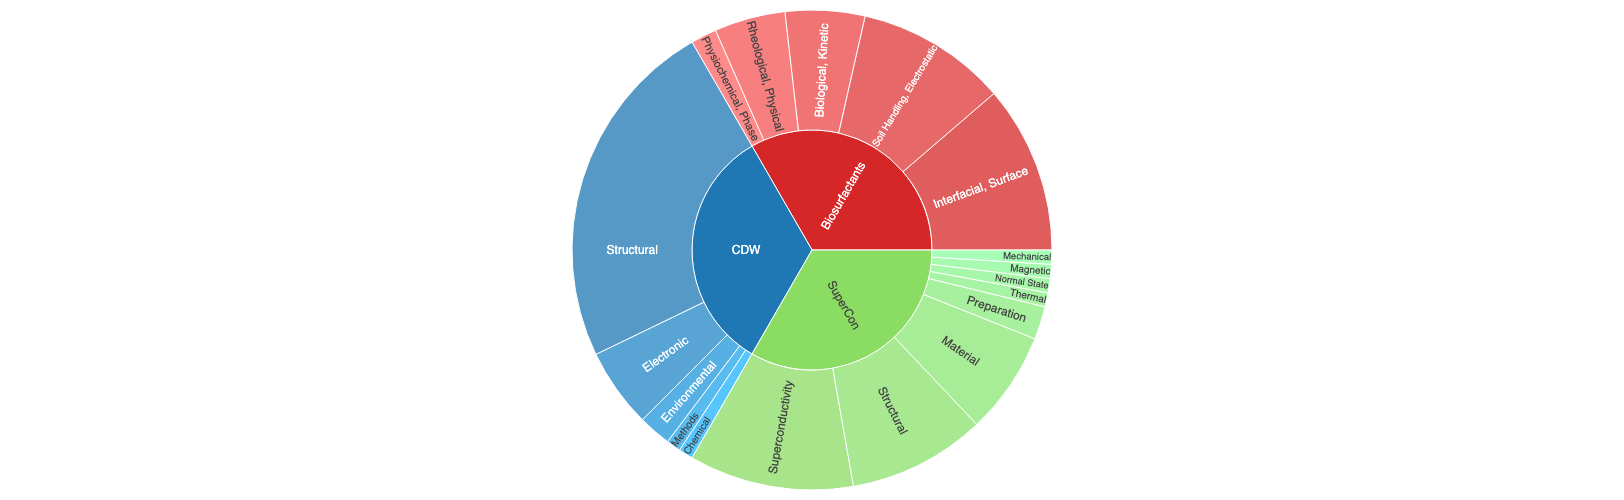

In [362]:
import math
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.colors import n_colors

CSV_PATH = "./all_data_categories.csv"
df = pd.read_csv(CSV_PATH)

# -----------------------------
# Validate / clean
# -----------------------------
required = {"dataset", "category", "property_name", "count"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing required columns: {sorted(missing)}")

df = df.copy()
df["dataset"] = df["dataset"].astype(str).str.strip()
df["category"] = df["category"].astype(str).str.strip()
df["property_name"] = df["property_name"].astype(str).str.strip()
df["count"] = pd.to_numeric(df["count"], errors="coerce").fillna(0)

def log10_clip(x: float) -> float:
    return math.log10(x if x > 0 else 1.0)

df["count_log10"] = df["count"].map(log10_clip)

# -----------------------------
# Collapse to Dataset -> Category (NO property nodes)
# -----------------------------
# We'll keep n_properties for hover, but the *area* will be driven by sum_count now.
g = (
    df.groupby(["dataset", "category"], as_index=False)
      .agg(
          n_properties=("property_name", "nunique"),
          mean_log10=("count_log10", "mean"),
          sum_count=("count", "sum"),
      )
)

# Dataset-level aggregates for hover + color
ds = (
    g.groupby("dataset", as_index=False)
     .agg(
         n_categories=("category", "nunique"),
         n_properties=("n_properties", "sum"),
         sum_count=("sum_count", "sum"),
     )
)

# Weighted mean log10 for dataset color (weights = n_properties, keep as you had)
ds_color = (
    g.assign(w=g["n_properties"])
     .groupby("dataset", as_index=False)
     .apply(lambda x: (x["mean_log10"] * x["w"]).sum() / max(x["w"].sum(), 1))
     .rename(columns={None: "mean_log10"})
)
ds = ds.merge(ds_color, on="dataset", how="left")

ds_sorted = ds.sort_values(["dataset"], kind="mergesort").reset_index(drop=True)

# Sort categories for stable rendering (big ones first)
g_sorted = g.sort_values(["dataset", "sum_count", "category"], ascending=[True, False, True])

# -----------------------------
# Colors: dataset base + per-dataset shade ramps for categories
# -----------------------------

RED_BASE = "rgb(214,39,40)"
BLUE_BASE = "rgb(31,119,180)"
GREEN_BASE = "rgb(138,220,99)"

DATASET_BASE_COLORS = {
    ds_name: base
    for ds_name, base in zip(
        ds_sorted["dataset"],
        [RED_BASE, BLUE_BASE, GREEN_BASE],
    )
}

base_color_endpoints = {
    RED_BASE: "rgb(255,100,100)",
    BLUE_BASE: "rgb(31,180,255)",
    GREEN_BASE: "rgb(138,255,160)",
}

node_colors = []

# Dataset nodes (inner ring)
for r in ds_sorted.itertuples(index=False):
    node_colors.append(DATASET_BASE_COLORS[r.dataset])

# Category nodes (outer ring): shades per dataset
for ds_name, sub in g_sorted.groupby("dataset", sort=False):
    base_color = DATASET_BASE_COLORS[ds_name]
    shades = n_colors(
        base_color,
        base_color_endpoints[base_color],
        len(sub),
        colortype="rgb",
    )
    node_colors.extend(shades)

# -----------------------------
# Build sunburst arrays
# -----------------------------
ids, labels, parents, values, customdata = [], [], [], [], []

DATASET_VALUE = 1.0  # equal area for each dataset wedge

# Totals for normalization (now using sum_count)
tot_count_by_ds = (
    g_sorted.groupby("dataset", as_index=True)["sum_count"].sum().to_dict()
)
n_cats_by_ds = (
    ds_sorted.set_index("dataset")["n_categories"].to_dict()
)

# Dataset nodes: equal thirds
for r in ds_sorted.itertuples(index=False):
    ds_id = f"ds::{r.dataset}"
    ids.append(ds_id)
    labels.append(r.dataset)
    parents.append("")
    values.append(DATASET_VALUE)

    customdata.append([
        int(r.n_categories),
        int(r.n_properties),
        float(r.sum_count),
        float(r.mean_log10),
    ])


# this sets how small the smallest categories can be
MIN_FRACTION = 0.03

# Category nodes: proportional to sum_count with minimum visible size
for ds_name, sub in g_sorted.groupby("dataset", sort=False):
    ds_id = f"ds::{ds_name}"

    raw = sub["sum_count"].astype(float).values
    total = raw.sum()

    if total > 0:
        fracs = raw / total
    else:
        fracs = pd.Series(
            [1.0 / len(sub)] * len(sub),
            index=sub.index
        ).values

    # Apply minimum size
    # Apply minimum size (NumPy-safe)
    fracs = np.maximum(fracs, MIN_FRACTION)

    # Renormalize so categories still fill the dataset wedge
    fracs = fracs / fracs.sum()

    for r, frac in zip(sub.itertuples(index=False), fracs):
        cat_id = f"cat::{r.dataset}::{r.category}"

        ids.append(cat_id)
        labels.append(r.category)
        parents.append(ds_id)
        values.append(DATASET_VALUE * float(frac))

        customdata.append([
            None,
            int(r.n_properties),
            float(r.sum_count),
            float(r.mean_log10),
        ])


# -----------------------------
# Sunburst figure
# -----------------------------
fig = go.Figure(
    go.Sunburst(
        ids=ids,
        labels=labels,
        parents=parents,
        values=values,
        branchvalues="total",
        customdata=customdata,
        insidetextorientation="radial",
        leaf=dict(opacity=0.84),
        hovertemplate=(
            "<b>%{label}</b><br>"
            "Properties: %{customdata[1]}<br>"
            "Sum count: %{customdata[2]:.0f}<br>"
            "<extra></extra>"
        ),
    ),
)

fig.update_layout(
    margin=dict(t=10, l=10, r=10, b=10),
    width=500,
    height=500,
    font=dict(family="sans-serif"),
)

fig.update_traces(
    marker=dict(
        colors=node_colors,
        line=dict(color="white", width=1),
    ),
    leaf=dict(opacity=0.75),
)

fig.show()

import plotly.io as pio

# Disable MathJax during static image/PDF export (prevents the loader box)
pio.kaleido.scope.mathjax = None

fig.write_image("taxonomy_sunburst.svg", width=500, height=500)
fig.write_image("taxonomy_sunburst.pdf", width=500, height=500)